## Import Data

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('QVI_data.csv')
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


## Data Clean

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [4]:
df = df.drop_duplicates().reset_index(drop=True)
df.shape

(264833, 12)

## Data Analysis

#### Converting date column into datetime & extracting month & year

In [21]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['MONTH_YEAR'] = df["DATE"].dt.strftime("%Y%m").astype("int")

#### Compiling each store's monthly data:
- Monthly sales revenue
- Monthly customers
- Monthly transaction per customer

In [27]:
monthly_data = df.groupby(['STORE_NBR', 'MONTH_YEAR']).agg(
    monthly_sales_revenue=('TOT_SALES', 'sum'),
    monthly_customers=('LYLTY_CARD_NBR', 'nunique'),
    transactions_per_customer=('TXN_ID', 'count'),
).reset_index()
monthly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3169 entries, 0 to 3168
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   STORE_NBR                  3169 non-null   int64  
 1   MONTH_YEAR                 3169 non-null   int32  
 2   monthly_sales_revenue      3169 non-null   float64
 3   monthly_customers          3169 non-null   int64  
 4   transactions_per_customer  3169 non-null   int64  
dtypes: float64(1), int32(1), int64(3)
memory usage: 111.5 KB


#### Filtering monthly data from July 2018 to January 2019 (pre-trial period)

In [48]:
observe_counts = monthly_data['STORE_NBR'].value_counts()
full_observe_index = observe_counts[observe_counts == 12].index
full_observe = monthly_data[monthly_data['STORE_NBR'].isin(full_observe_index)]
df_before = full_observe[(full_observe['MONTH_YEAR'] >= 201807) & (full_observe['MONTH_YEAR'] <= 201901)]
df_before

,STORE_NBR,MONTH_YEAR,monthly_sales_revenue,monthly_customers,transactions_per_customer
0,1,201807,206.9,49,52
1,1,201808,176.1,42,43
2,1,201809,278.8,59,62
3,1,201810,188.1,44,45
4,1,201811,192.6,46,47
...,...,...,...,...,...
3159,272,201809,304.7,32,36
3160,272,201810,430.6,44,51
3161,272,201811,376.2,41,45
3162,272,201812,403.9,47,47


#### Finding control stores for each of the trial stores
- Trial Store 77: Control Store 233
- Trial Store 86: Control Store 155
- Trial Store 88: Control Store 40

In [40]:
trial_stores = [77, 86, 88]
control_stores = {}
MIN_CORRELATION_THRESHOLD = 0.7

for trial_store in trial_stores:
    trial_data = df_before[df_before['STORE_NBR'] == trial_store]
    max_correlation = -1
    best_store = None
    
    for store in df_before['STORE_NBR'].unique():
        if store == trial_store:
            continue
        control_data = df_before[df_before['STORE_NBR'] == store]
        merged_data = pd.merge(
            trial_data, control_data, on='MONTH_YEAR', suffixes=('_trial', '_control')
        )
        
        if len(merged_data) < 2:
            continue  
        try:
            sales_corr, _ = pearsonr(merged_data['monthly_sales_revenue_trial'], 
                                     merged_data['monthly_sales_revenue_control'])
            customers_corr, _ = pearsonr(merged_data['monthly_customers_trial'], 
                                         merged_data['monthly_customers_control'])
            transactions_corr, _ = pearsonr(merged_data['transactions_per_customer_trial'], 
                                            merged_data['transactions_per_customer_control'])
            avg_corr = (sales_corr + customers_corr + transactions_corr) / 3
        
            if avg_corr > max_correlation and avg_corr >= MIN_CORRELATION_THRESHOLD:
                max_correlation = avg_corr
                best_store = store
        except Exception as e:
            print(f"Skipping store {store} due to error: {e}")
    control_stores[trial_store] = best_store

print(control_stores)

{77: 233, 86: 155, 88: 14}


## Data Visualization

#### Visualized comparison between trial and control store during the pre-trial period (July 2018 to January 2019)

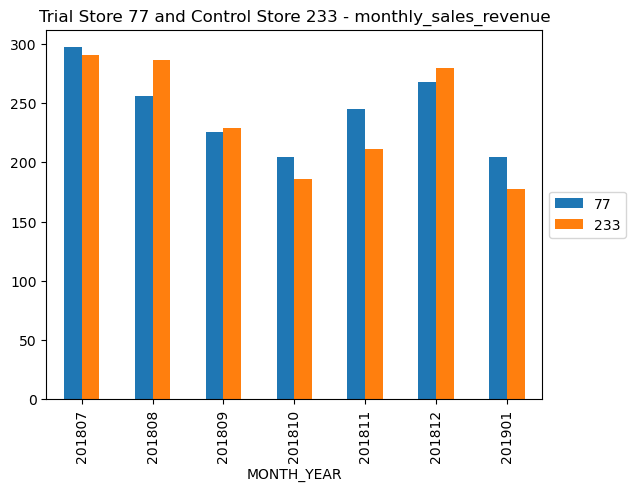

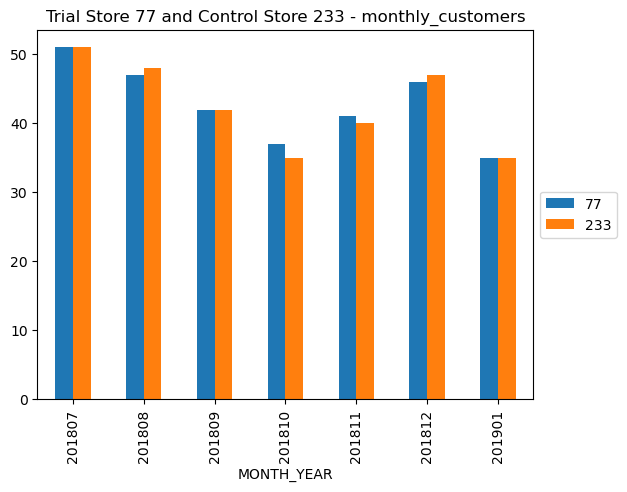

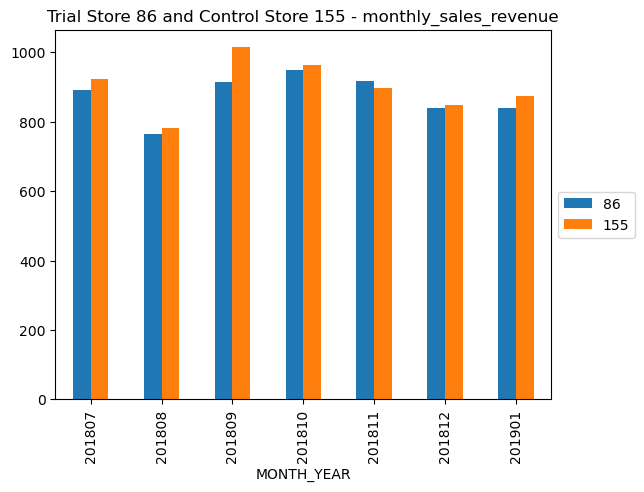

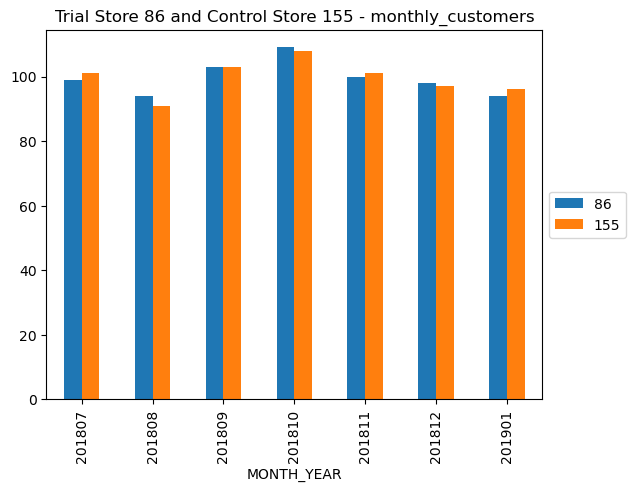

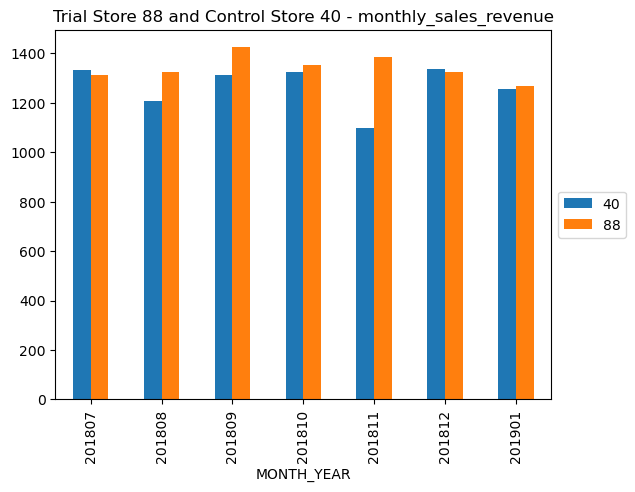

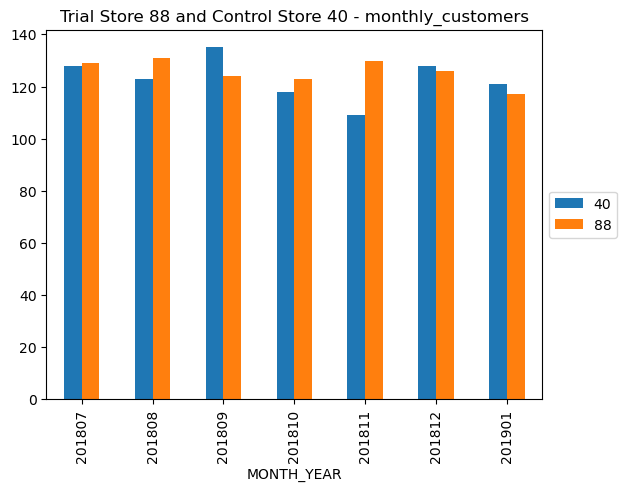

In [44]:
trial_control_dic = {77: 233, 86: 155, 88: 40}

for trial_store, control_store in trial_control_dic.items():
    trial_control_data = df_before[df_before["STORE_NBR"].isin([trial_store, control_store])]
    numeric_columns = ["monthly_sales_revenue", "monthly_customers"]    
    trial_control_data.groupby(["MONTH_YEAR", "STORE_NBR"])[numeric_columns].sum()["monthly_sales_revenue"].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title(f"Trial Store {trial_store} and Control Store {control_store} - monthly_sales_revenue")
    plt.show() 
    trial_control_data.groupby(["MONTH_YEAR", "STORE_NBR"])[numeric_columns].sum()["monthly_customers"].unstack().plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title(f"Trial Store {trial_store} and Control Store {control_store} - monthly_customers")
    plt.show()
    print("\n")

#### Visualized comparison of monthly sales revenue between trial and control store during the trial period (February 2019 to April 2019)

In [46]:
sales_ratio_77 = df_before[df_before["STORE_NBR"] == 77]["monthly_sales_revenue"].sum() / df_before[df_before["STORE_NBR"] == 233]["monthly_sales_revenue"].sum()
sales_ratio_86 = df_before[df_before["STORE_NBR"] == 86]["monthly_sales_revenue"].sum() / df_before[df_before["STORE_NBR"] == 155]["monthly_sales_revenue"].sum()
sales_ratio_88 = df_before[df_before["STORE_NBR"] == 88]["monthly_sales_revenue"].sum() / df_before[df_before["STORE_NBR"] == 40]["monthly_sales_revenue"].sum()

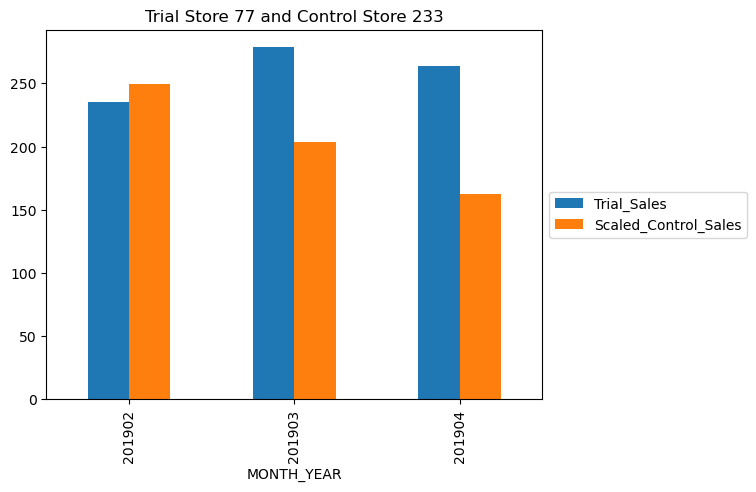

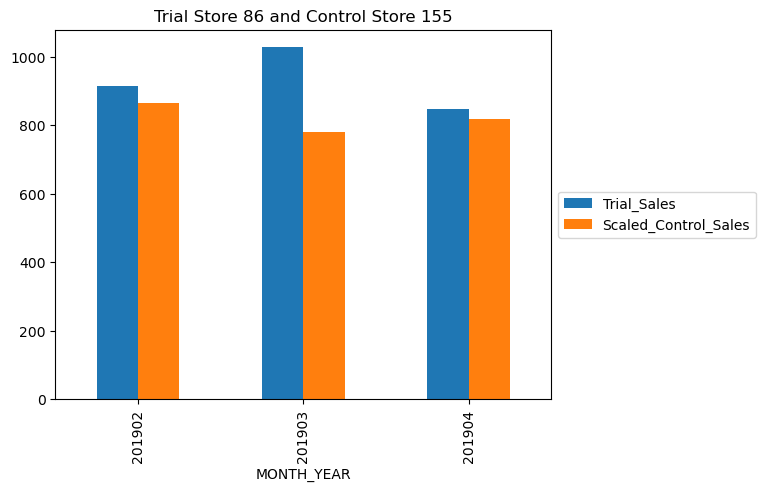

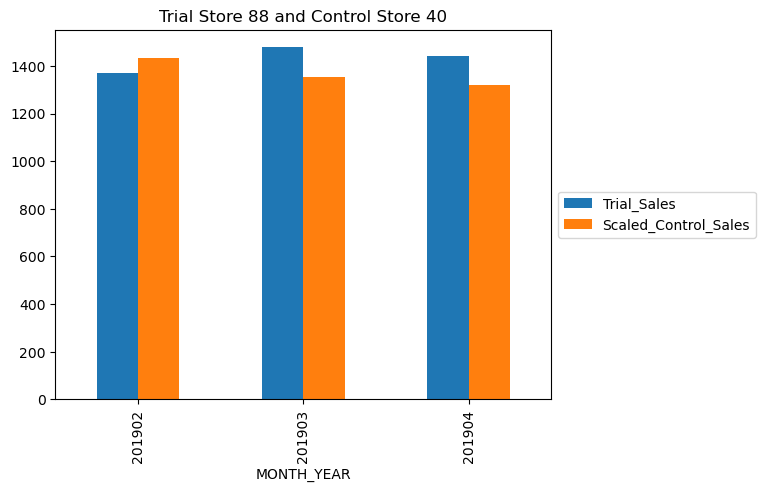

In [52]:
trial_full_observ = full_observe[(full_observe["MONTH_YEAR"] >= 201902) & (full_observe["MONTH_YEAR"] <= 201904)]
scaled_sales_control_stores = full_observe[full_observe["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "MONTH_YEAR", "monthly_sales_revenue"]]

def scaler(row):
    if row["STORE_NBR"] == 233:
        return row["monthly_sales_revenue"] * sales_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["monthly_sales_revenue"] * sales_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["monthly_sales_revenue"] * sales_ratio_88

scaled_sales_control_stores["ScaledSales"] = scaled_sales_control_stores.apply(lambda row: scaler(row), axis=1)
trial_scaled_sales_control_stores = scaled_sales_control_stores[(scaled_sales_control_stores["MONTH_YEAR"] >= 201902) & (scaled_sales_control_stores["MONTH_YEAR"] <= 201904)]
pretrial_scaled_sales_control_stores = scaled_sales_control_stores[scaled_sales_control_stores["MONTH_YEAR"] < 201902]
percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_sales_control_stores[trial_scaled_sales_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "MONTH_YEAR", "monthly_sales_revenue"]]
    percentage_diff[trial] = b["monthly_sales_revenue"].sum() / a["ScaledSales"].sum()
    b[["MONTH_YEAR", "monthly_sales_revenue"]].merge(a[["MONTH_YEAR", "ScaledSales"]], on="MONTH_YEAR").set_index("MONTH_YEAR").rename(columns={"ScaledSales": "Scaled_Control_Sales", "monthly_sales_revenue": "Trial_Sales"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title(f"Trial Store {trial} and Control Store {control}")  

In [56]:
percentage_diff

{77: 1.2615468650086281, 86: 1.1315014357363697, 88: 1.043458345854219}

#### Visualized comparison of monthly customers between trial and control store during the trial period (February 2019 to April 2019)

In [57]:
no_of_cust_ratio_77 = df_before[df_before["STORE_NBR"] == 77]["monthly_customers"].sum() / df_before[df_before["STORE_NBR"] == 233]["monthly_customers"].sum()
no_of_cust_ratio_86 = df_before[df_before["STORE_NBR"] == 86]["monthly_customers"].sum() / df_before[df_before["STORE_NBR"] == 155]["monthly_customers"].sum()
no_of_cust_ratio_88 = df_before[df_before["STORE_NBR"] == 88]["monthly_customers"].sum() / df_before[df_before["STORE_NBR"] == 40]["monthly_customers"].sum()

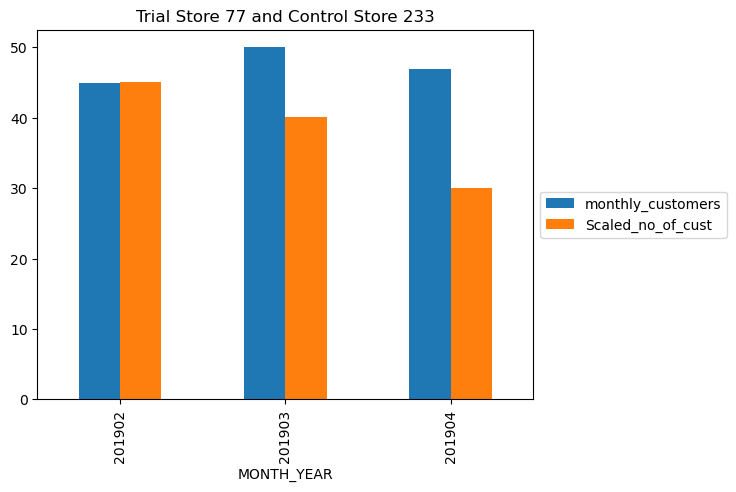

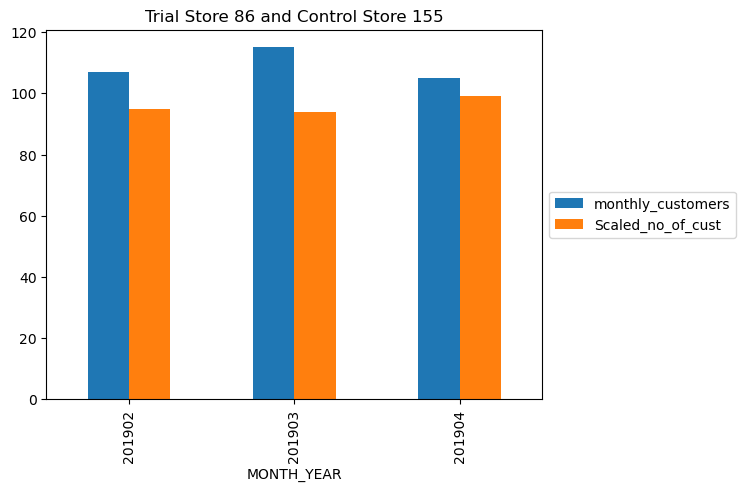

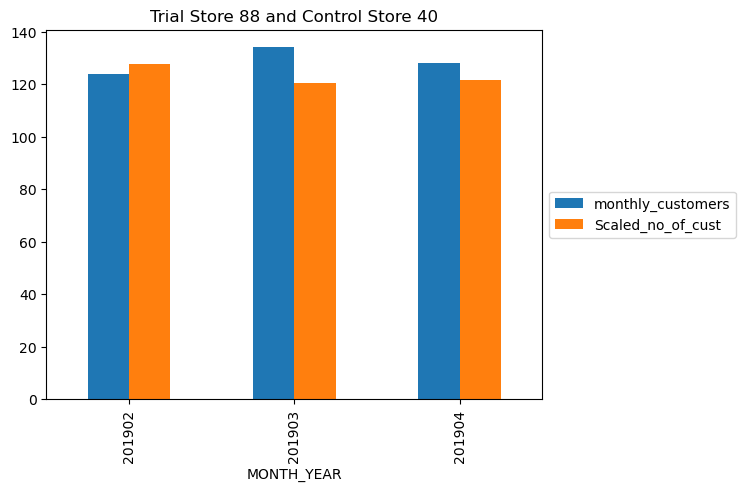

In [67]:
scaled_no_of_cust_control_stores = full_observe[full_observe["STORE_NBR"].isin([233, 155, 40])][["STORE_NBR", "MONTH_YEAR", "monthly_customers"]]

def scaler_c(row):
    if row["STORE_NBR"] == 233:
        return row["monthly_customers"] * no_of_cust_ratio_77
    elif row["STORE_NBR"] == 155:
        return row["monthly_customers"] * no_of_cust_ratio_86
    elif row["STORE_NBR"] == 40:
        return row["monthly_customers"] * no_of_cust_ratio_88

scaled_no_of_cust_control_stores["Scaled_no_of_cust"]= scaled_no_of_cust_control_stores.apply(lambda row: scaler(row), axis=1)
trial_scaled_no_of_cust_control_stores = scaled_no_of_cust_control_stores[(scaled_no_of_cust_control_stores["MONTH_YEAR"] >= 201902) & (scaled_no_of_cust_control_stores["MONTH_YEAR"] <= 201904)]
pretrial_scaled_no_of_cust_control_stores = scaled_no_of_cust_control_stores[scaled_no_of_cust_control_stores["MONTH_YEAR"] < 201902]
no_of_cust_percentage_diff = {}

for trial, control in trial_control_dic.items():
    a = trial_scaled_no_of_cust_control_stores[trial_scaled_no_of_cust_control_stores["STORE_NBR"] == control]
    b = trial_full_observ[trial_full_observ["STORE_NBR"] == trial][["STORE_NBR", "MONTH_YEAR", "monthly_customers"]]
    no_of_cust_percentage_diff[trial] = b["monthly_customers"].sum() / a["Scaled_no_of_cust"].sum()
    b[["MONTH_YEAR", "monthly_customers"]].merge(a[["MONTH_YEAR", "Scaled_no_of_cust"]], on="MONTH_YEAR").set_index("MONTH_YEAR").rename(columns={"ScaledSales":"Scaled_Control_nCust", "TOT_SALES":"Trial_nCust"}).plot.bar()
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title("Trial Store "+str(trial)+" and Control Store "+str(control))

In [69]:
no_of_cust_percentage_diff

{77: 1.2306529009742622, 86: 1.1354166666666667, 88: 1.0444876946258161}

#### Findings

- Trial store 77: Control store 233
- Trial store 86: Control store 155
- Trial store 88: Control store 40
- All three trial store showed significant increase in Total Sales and Number of Customers during trial period
- Overall the trial showed a positive results